Created in 2022

@author: quoc-thong nguyen

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import time
# import time
warnings.filterwarnings("ignore")
from clustering_function import Clustering_constraint
from distance_functions import *
from VRPTW import *
from dotenv import load_dotenv

load_dotenv()
API = os.environ["API"]

# LOAD DATASET

In [3]:
dire = os.getcwd()+'/data/Data_LAD-2.csv'
df = pd.read_csv(dire)
df = df.iloc[:,1:]
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
df['FIN CRÉNEAUX'] = pd.to_datetime(df['FIN CRÉNEAUX'])
df['DÉBUT CRÉNEAUX'] = pd.to_datetime(df['DÉBUT CRÉNEAUX'])
df['WDAY'] = [val.date().weekday() for val in df['DATE']]
df['begin_time'] = df['DÉBUT CRÉNEAUX'].dt.hour
df['1/2day'] = 0 # morning
df['1/2day'][df['begin_time']>14] = 1 #afternoon 14

# VISULIZATION OF DESTINATIONS ON MAP

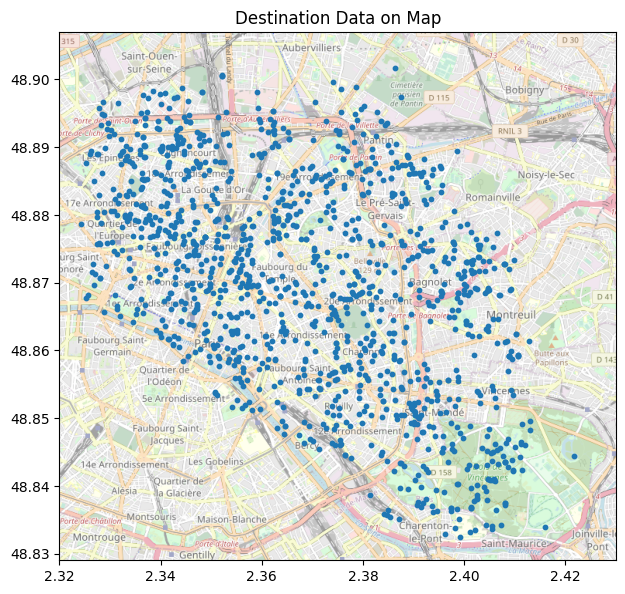

In [4]:
# ALL LOCATIONS
dfCOOR = df[['LATITUDE','LONGITUDE']]
BBox = (2.32,2.43,48.829, 48.907)
ruh_m = plt.imread('data/map.png')
px = 1/plt.rcParams['figure.dpi']
fig, ax = plt.subplots(figsize = (718*px, 686*px))
ax.scatter(dfCOOR.LONGITUDE, dfCOOR.LATITUDE, alpha= 1,
           cmap = 'cividis', s=10)
ax.set_title('Destination Data on Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0,alpha=.69, extent = BBox, aspect= 'auto')
# plt.savefig("map.eps", bbox_inches='tight', format='eps')

# VRP CALCULATION

In [ ]:
#-Le dépôt : 48.8876052, 2.3527115
DEPOT = [2.3527115,48.8876052]
# AVGspeed = 13100/60         #13.1km/h
flag: bool = False               # False:space; True:space-time
VEHICLE = 'driving-car'          # driving-car, cycling-electric, foot-hiking
D: int = 6                       # 6 days, Monday -> Saturday
K: int = 2                       # 2 timeframes, morning, afternoon
Ntour = np.empty([D, K]) 
Nclient = np.empty([D, K])
Distance = np.empty([D, K])
Time_ = np.empty([D, K])
request_count = 0
NbacTour = []
TpRoute = []; DpRoute = []; CusProute = []
ServiceTime = 6             # minutes
# Data preparation
Nbac = 75                   # max number of BACS per vehicle
m = 2; BacPclus = m*Nbac    # N of BIN per cluster, m vans expected

#------------------------------------------------
for d in range(D): # day in week 0->5
    # if d == 5: AVGspeed = 14700/60
    for hday in range(K): # 0: morning, 1: afternoon, 2: evening
        NbacTouri = []
        CLIENTSi = df[(df['WDAY'] == d) & (df['1/2day'] == hday)][['ID','LATITUDE','LONGITUDE',
                                                           'DÉBUT CRÉNEAUX','FIN CRÉNEAUX',
                                                           '# BACS','begin_time']]
        CLIENTSi['CLUSTER'] = 0
        #-Clustering the clients with size constraints-
        if CLIENTSi['# BACS'].sum()>BacPclus:
            CLIENTSi, sum_clus, centers = Clustering_constraint(CLIENTSi, BacPclus, flag) # by BIN
        Nclient[d][hday] = len(CLIENTSi)

        Nv = dist = TotalTime = 0
        print('\n day: {}'.format(d),'timeframe: {}'.format(hday))
        for c in CLIENTSi['CLUSTER'].unique():
            if request_count == 55:
                request_count = 0
                time.sleep(60)
            request_count += 1
            CLUSk = CLIENTSi[CLIENTSi['CLUSTER'] == c]
            CLUSk = CLUSk.reset_index(drop=True)
            CLUSk.index += 1
            # COORk array of Geo coodinates
            COORk2 = CLUSk[['LONGITUDE','LATITUDE']]
            COORk2 = COORk2.values.tolist()
            COORk2.insert(0,DEPOT)
            # time window
            w = .75     # presented at the depot before the first command, 45m for van, 30m for bike
            startH = min(CLUSk['DÉBUT CRÉNEAUX'].dt.hour) - w
            endH = startH + 5

            c_TIME = 60
            TIME_start = c_TIME*startH

            CLUSk['start'] = c_TIME*CLUSk['DÉBUT CRÉNEAUX'].dt.hour-TIME_start
            CLUSk['begin_time'] = c_TIME*CLUSk['DÉBUT CRÉNEAUX'].dt.hour - TIME_start

            CLUSk['end'] = c_TIME*CLUSk['FIN CRÉNEAUX'].dt.hour-TIME_start

            t_depot = (0,c_TIME*(endH-startH))
            TW = list(CLUSk[['start','end']].to_records(index = False))
            TW.insert(0,t_depot); test = [tuple(map(int,x)) for x in TW]
            TW = test

            Response = send_request(COORk2, VEHICLE, API)
            Distance_Matrix = np.array(Response['distances'])                                 # distance matrix
            T_round = np.asmatrix(np.round(np.array(Response['durations'])/60)) # compute time matrix
            # T_round = np.asmatrix(np.round(D/AVGspeed))
            T_round[1:,1:] += ServiceTime
            for i in range(len(T_round)):
                T_round[i,i] = 0
            T_round = np.asarray(T_round)
            T_round = [list(map(int,x)) for x in T_round]
            BacLim = list(CLUSk['# BACS'])
            BacLim.insert(0,0)
            # create data to solve VRP with TW
            data = create_data_modelTW()
            data['demands'] = BacLim
            data['time_matrix'] = T_round
            data['time_windows'] = TW
            data['num_vehicles'] = int(np.ceil(CLUSk['# BACS'].sum()/Nbac))+7
            data['depot'] = 0
            data['vehicle_capacities'] = list(np.ones(data['num_vehicles'], dtype=int)*Nbac)

            route, TIME, total_time, time_p_route, Nveh = SolveProblemTW(data)

            for x in route:
                NbacTouri.append(CLUSk.loc[[num for num in x if num != 0]]['# BACS'].sum())
                CusProute.append(len(CLUSk.loc[[num for num in x if num != 0]]))
            CusProute = [n for n in CusProute if n != 0]
            NbacTouri = [n for n in NbacTouri if n != 0]
            TpRoute += [(Tr+ServiceTime) for Tr in time_p_route]
            total_time = (total_time + ServiceTime*Nveh)/60
            Nv += Nveh
            total_dist, Dtour = route_distance(route, Distance_Matrix)
            total_dist /= 1000
            DpRoute += Dtour

            TotalTime += total_time
            dist += total_dist
            print('N vans: {} for cluster {}'.format(Nveh, c))
            print('Total sevice time for cluster {}: {} h'.format(c, total_time))
            print('total service distance for cluster {}: {} km'.format(c, total_dist))

        NbacTour.append(NbacTouri)
        Ntour[d][hday] = Nv
        Distance[d][hday] = dist
        Time_[d][hday] = TotalTime


print(f'mean time/tour: {np.mean(TpRoute)/60} and std time/tour: {np.std(TpRoute)/60}')

In [ ]:
print(f'total distance: {Distance.sum()} km')
print(f'total tour {Ntour.sum()} tours')
print(f'total time: {Time_.sum()} h')